In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, Normalizer, LabelEncoder

%matplotlib inline

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
test["is_promoted"] = np.nan
print train.shape, test.shape

(54808, 14) (23490, 14)


# Simple LGBM Model

In [3]:
train_id = train[["employee_id"]]
test_id = test[["employee_id"]]
target = train.is_promoted

train = train.drop(["employee_id","is_promoted"], axis=1)
test = test.drop(["employee_id","is_promoted"], axis=1)

data = pd.concat([train, test], axis=0).reset_index(drop=True)
data["previous_year_rating"] = data["previous_year_rating"].fillna(0)
data["education"] = data["education"].fillna("NoData")

# Feature Engineering Start
data["department_size"] = data["department"].map(data.groupby("department").size())

data["department_average_training_scores"] = data["department"].map(data.groupby("department")["avg_training_score"].apply(lambda x: np.array(x)))
data["percentile_average_training_score_in_department"] = data.apply(lambda x: ((x["department_average_training_scores"] < x["avg_training_score"]).astype(int).sum() + ((x["department_average_training_scores"] == x["avg_training_score"]).astype(int).sum()*0.5))/len(x["department_average_training_scores"]), axis=1)
data["t_average_training_score_in_department"] = data.apply(lambda x: (np.mean(x["department_average_training_scores"]) - x["avg_training_score"])/(np.std(x["department_average_training_scores"])/np.sqrt(len(x["department_average_training_scores"]))), axis=1)
data = data.drop(["department_average_training_scores"], axis=1)

data["kpi_positive_department_average_training_scores"] = data["department"].map(data.loc[data["KPIs_met >80%"] ==1].groupby("department")["avg_training_score"].apply(lambda x: np.array(x)))
data["percentile_kpi_positive_average_training_score_in_department"] = data.apply(lambda x: ((x["kpi_positive_department_average_training_scores"] < x["avg_training_score"]).astype(int).sum() + ((x["kpi_positive_department_average_training_scores"] == x["avg_training_score"]).astype(int).sum()*0.5))/len(x["kpi_positive_department_average_training_scores"]), axis=1)
data = data.drop(["kpi_positive_department_average_training_scores"], axis=1)

# Feature Engineering End


data = pd.get_dummies(data, columns = data.select_dtypes(include='object').columns)

train = data[:train.shape[0]]
test = data[train.shape[0]:]

In [4]:
def f1_score_calculator(y_true, y_pred):
    bst = 0
    split_by = 0.0
    for i in range(100):
        fs = f1_score(y_true, (y_pred>i/100.0).astype(int))
        if fs > bst:
            bst , split_by = fs, i/100.0
        else:
            pass
    return split_by, bst 

In [5]:
import lightgbm as lgb
def model_tree(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_test, label=y_test)
    params = {
        'num_leaves': 32, 
        'reg_alpha': 0.04, 
        'n_jobs': -1, 
        'colsample_bytree': 0.9497036, 
        'silent': -1, 
        'subsample_for_bin': 200000, 
        'subsample_freq': 1, 
        'learning_rate': 0.02, 
        'boosting_type': 'gbdt', 
        'nthread': 8, 
        'min_child_weight': 40, 
        'min_split_gain': 0.0222415, 
        'n_estimators': 10000, 
        'subsample': 0.8715623, 
        'reg_lambda': 0.073, 
        'objective': "binary",
        'verbose': -1, 
        'min_child_samples': 20, 
        'max_depth': 4, 
        'class_weight': None,
        "nthread":8,
        "bagging_seed" : 42,
        "seed":98,
        "metric":"auc"
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    split, bst = f1_score_calculator(y_test, meta_train[test_index])
    
    meta_train[test_index] = (meta_train[test_index] > split).astype(int)
    meta_test.append((model.predict(test, num_iteration=model.best_iteration or 5000) > split).astype(int))
    
    print "Fold {} best Split {} and best Score {}".format(fold_id,split, bst)
        
    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    fold_feature_importance = pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()})
    feature_importance = feature_importance.append(fold_feature_importance, ignore_index=True) 

In [6]:
meta_train = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame()

kf = StratifiedKFold(n_splits= 50, shuffle=True, random_state=1343)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

    model_tree(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)
print "Overall Score: {}".format(f1_score(target, meta_train))

train_id["is_promoted"] = meta_train
test_id["is_promoted"] = (np.array(meta_test).T.mean(axis=1) > 0.5).astype(int)

/anaconda2/lib/python2.7/site-packages/lightgbm/engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903601	valid_1's auc: 0.902781
[200]	training's auc: 0.91067	valid_1's auc: 0.905894
[300]	training's auc: 0.913379	valid_1's auc: 0.905958
[400]	training's auc: 0.916098	valid_1's auc: 0.905406
Early stopping, best iteration is:
[248]	training's auc: 0.912175	valid_1's auc: 0.907305
Fold 0 best Split 0.23 and best Score 0.544217687075


/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903741	valid_1's auc: 0.91099
[200]	training's auc: 0.910317	valid_1's auc: 0.917513
[300]	training's auc: 0.913091	valid_1's auc: 0.920064
[400]	training's auc: 0.915652	valid_1's auc: 0.92077
[500]	training's auc: 0.917422	valid_1's auc: 0.921406
[600]	training's auc: 0.918922	valid_1's auc: 0.922297
[700]	training's auc: 0.920219	valid_1's auc: 0.922329
[800]	training's auc: 0.921254	valid_1's auc: 0.921671
Early stopping, best iteration is:
[633]	training's auc: 0.919336	valid_1's auc: 0.922392
Fold 1 best Split 0.27 and best Score 0.601307189542
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.902928	valid_1's auc: 0.913716
[200]	training's auc: 0.91025	valid_1's auc: 0.923464
[300]	training's auc: 0.912803	valid_1's auc: 0.923077
[400]	training's auc: 0.915573	valid_1's auc: 0.925983
[500]	training's auc: 0.917336	valid_1's auc: 0.926815
[600]	training's au

[300]	training's auc: 0.912936	valid_1's auc: 0.933831
Early stopping, best iteration is:
[183]	training's auc: 0.909262	valid_1's auc: 0.934563
Fold 13 best Split 0.26 and best Score 0.597222222222
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903806	valid_1's auc: 0.89489
[200]	training's auc: 0.91055	valid_1's auc: 0.901529
[300]	training's auc: 0.91315	valid_1's auc: 0.904558
[400]	training's auc: 0.915646	valid_1's auc: 0.905512
[500]	training's auc: 0.917422	valid_1's auc: 0.906016
[600]	training's auc: 0.919023	valid_1's auc: 0.90679
[700]	training's auc: 0.920522	valid_1's auc: 0.907077
[800]	training's auc: 0.921584	valid_1's auc: 0.90748
[900]	training's auc: 0.922552	valid_1's auc: 0.908636
[1000]	training's auc: 0.923379	valid_1's auc: 0.909378
[1100]	training's auc: 0.924179	valid_1's auc: 0.909654
[1200]	training's auc: 0.924958	valid_1's auc: 0.909919
[1300]	training's auc: 0.925676	valid_1's auc: 0.91045
[1400]	training's auc: 0.

[400]	training's auc: 0.915556	valid_1's auc: 0.923509
[500]	training's auc: 0.917209	valid_1's auc: 0.924817
[600]	training's auc: 0.918726	valid_1's auc: 0.925546
[700]	training's auc: 0.920075	valid_1's auc: 0.925857
[800]	training's auc: 0.921168	valid_1's auc: 0.926157
[900]	training's auc: 0.922237	valid_1's auc: 0.925953
Early stopping, best iteration is:
[729]	training's auc: 0.920332	valid_1's auc: 0.926414
Fold 25 best Split 0.24 and best Score 0.625
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.904001	valid_1's auc: 0.899709
[200]	training's auc: 0.910408	valid_1's auc: 0.901773
[300]	training's auc: 0.913346	valid_1's auc: 0.904276
[400]	training's auc: 0.915847	valid_1's auc: 0.905756
[500]	training's auc: 0.917663	valid_1's auc: 0.907214
[600]	training's auc: 0.91908	valid_1's auc: 0.90835
[700]	training's auc: 0.920336	valid_1's auc: 0.910055
[800]	training's auc: 0.921397	valid_1's auc: 0.910484
[900]	training's auc: 0.922442	val

[200]	training's auc: 0.910528	valid_1's auc: 0.899522
[300]	training's auc: 0.913392	valid_1's auc: 0.904973
[400]	training's auc: 0.91574	valid_1's auc: 0.908457
[500]	training's auc: 0.917294	valid_1's auc: 0.911186
[600]	training's auc: 0.918673	valid_1's auc: 0.912435
[700]	training's auc: 0.920025	valid_1's auc: 0.912906
[800]	training's auc: 0.921168	valid_1's auc: 0.913325
[900]	training's auc: 0.922002	valid_1's auc: 0.913475
[1000]	training's auc: 0.922943	valid_1's auc: 0.913174
Early stopping, best iteration is:
[826]	training's auc: 0.921354	valid_1's auc: 0.913657
Fold 37 best Split 0.25 and best Score 0.506329113924
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.903444	valid_1's auc: 0.908179
[200]	training's auc: 0.910503	valid_1's auc: 0.916766
[300]	training's auc: 0.913518	valid_1's auc: 0.917012
[400]	training's auc: 0.915722	valid_1's auc: 0.916959
[500]	training's auc: 0.917438	valid_1's auc: 0.917784
[600]	training's auc: 0

[700]	training's auc: 0.920348	valid_1's auc: 0.914064
[800]	training's auc: 0.921381	valid_1's auc: 0.913914
Early stopping, best iteration is:
[623]	training's auc: 0.919462	valid_1's auc: 0.914408
Fold 49 best Split 0.28 and best Score 0.540145985401
Overall Score: 0.543003851091


In [7]:
test_id.to_csv("csv/prediction4.csv", index = False)

In [8]:
test_id["is_promoted"].mean()

0.04776500638569604

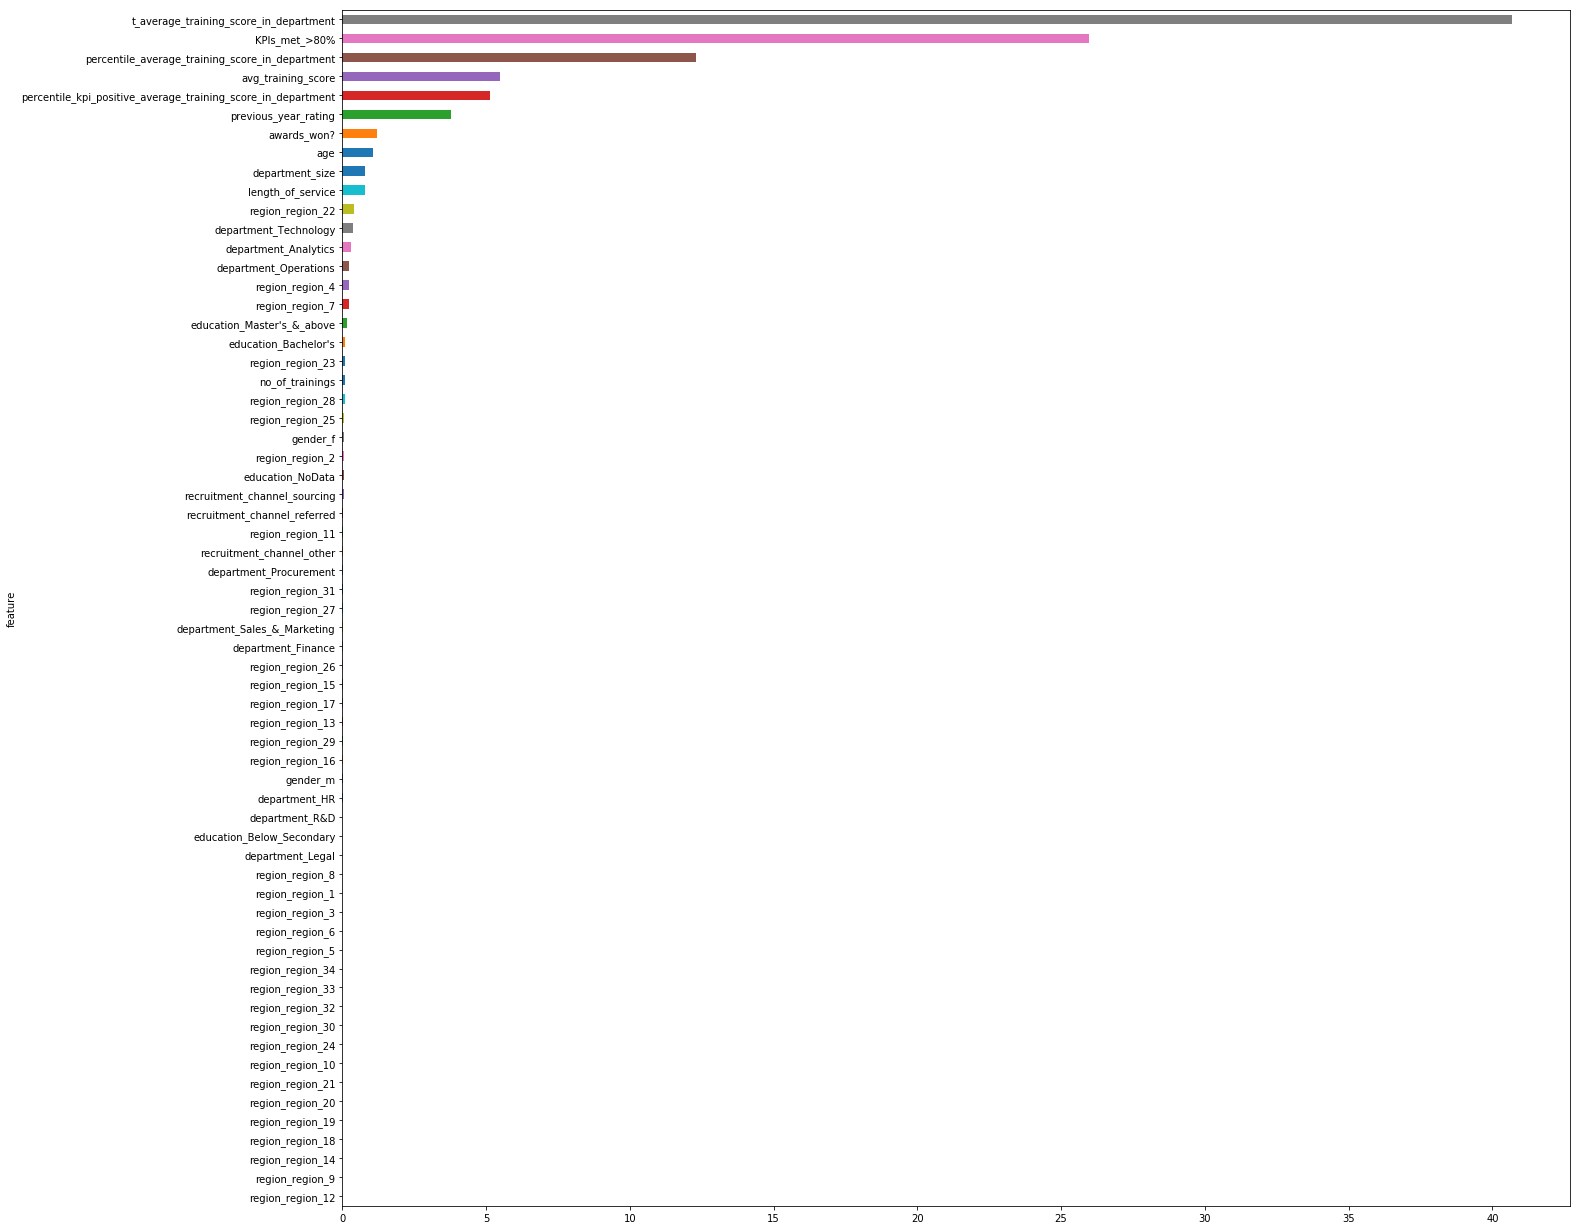

In [9]:
feature_importance.groupby("feature")["gain"].mean().sort_values().plot(kind = "barh", figsize = (22,22))